In [1]:
# Read in and clean data
import nltk
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
import string
#nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')

In [2]:
data=pd.read_csv('IMDB Dataset.csv')

In [3]:
data.shape

(10000, 2)

In [4]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
data=data[:5000]

In [6]:
data.shape

(5000, 2)

In [7]:
data['sentiment'].value_counts()

negative    2532
positive    2468
Name: sentiment, dtype: int64

# clean_text

In [18]:
data['sentiment']=np.where(data['sentiment']=='positive',1,0) 

In [19]:
def clean_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [word for word in tokens if word not in stopwords]
    return text

data['clean_review'] = data['review'].apply(lambda x: clean_text(x))
data.head()

,review,sentiment,clean_review
0,One of the other reviewers has mentioned that ...,1,"[one, reviewers, mentioned, watching, 1, oz, e..."
1,A wonderful little production. <br /><br />The...,1,"[wonderful, little, production, br, br, filmin..."
2,I thought this was a wonderful way to spend ti...,1,"[thought, wonderful, way, spend, time, hot, su..."
3,Basically there's a family where a little boy ...,0,"[basically, theres, family, little, boy, jake,..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,"[petter, matteis, love, time, money, visually,..."


In [20]:
# Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(data['clean_review'],
                                                    data['sentiment'], test_size=0.2)

# Build Model On TF-IDF Vectors

## Create TF-IDF Vectors

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [22]:
X_train=X_train.apply(lambda x: ' '.join(x))
X_test=X_test.apply(lambda x: ' '.join(x))

In [23]:
tfidf_vect = TfidfVectorizer()
tfidf_vect.fit(X_train)
X_train_vect = tfidf_vect.transform(X_train)
X_test_vect = tfidf_vect.transform(X_test)

## RandomForestClassifier

In [24]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf_model = rf.fit(X_train_vect, y_train.values.ravel())

In [25]:
# Use the trained model to make predictions on the test data
y_pred = rf_model.predict(X_test_vect)

In [26]:
# Evaluate the predictions of the model on the holdout test set
from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print('Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(precision, 3), round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))

Precision: 0.87 / Recall: 0.827 / Accuracy: 0.853


In [27]:
import sklearn.metrics as metrics
confusion = metrics.confusion_matrix(y_test, y_pred)
print(f"Confusion matrix:\n{confusion}")

Confusion matrix:
[[443  61]
 [ 86 410]]


# Build Model On word2vec Vectors

## # Train a basic word2vec model

In [28]:
import gensim
w2v_model = gensim.models.Word2Vec(X_train,
                                   size=100,
                                   window=5,
                                   min_count=2)

In [29]:
# Replace the words in each text message with the learned word vector
words = set(w2v_model.wv.index2word)
X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_train])
X_test_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_test])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [30]:
X_train_vect_avg = []
for v in X_train_vect:
    if v.size:
        X_train_vect_avg.append(v.mean(axis=0))
    else:
        X_train_vect_avg.append(np.zeros(100, dtype=float))
        
X_test_vect_avg = []
for v in X_test_vect:
    if v.size:
        X_test_vect_avg.append(v.mean(axis=0))
    else:
        X_test_vect_avg.append(np.zeros(100, dtype=float))

## RandomForestClassifier

In [31]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf_model = rf.fit(X_train_vect_avg, y_train.values.ravel())

In [32]:
y_pred = rf_model.predict(X_test_vect_avg)

In [33]:
from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print('Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(precision, 3), round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))

Precision: 0.575 / Recall: 0.518 / Accuracy: 0.571


In [34]:
import sklearn.metrics as metrics
confusion = metrics.confusion_matrix(y_test, y_pred)
print(f"Confusion matrix:\n{confusion}")

Confusion matrix:
[[314 190]
 [239 257]]


# RNN

In [35]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [36]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [37]:
# Pad the sequences so each sequence is the same length
X_train_seq_padded = pad_sequences(X_train_seq, 100)
X_test_seq_padded = pad_sequences(X_test_seq, 100)

In [38]:
#### metrics
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.models import Sequential

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

In [39]:
# Construct our basic RNN model framework
model = Sequential()

model.add(Embedding(len(tokenizer.index_word)+1, 32))
model.add(LSTM(32, dropout=0.5, recurrent_dropout=0.5))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          1458240   
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,469,761
Trainable params: 1,469,761
Non-trainable params: 0
______________________________________________

In [40]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', precision_m, recall_m])

In [41]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=5)

In [42]:
# Fit the RNN
history = model.fit(X_train_seq_padded, y_train.values, 
                    batch_size=32, epochs=30,
                    validation_data=(X_test_seq_padded, y_test.values),
                   callbacks=[early_stop])

Epoch 1/30
125/125 [==============================] - 15s 97ms/step - loss: 0.6242 - accuracy: 0.6260 - precision_m: 0.5863 - recall_m: 0.5253 - val_loss: 0.3841 - val_accuracy: 0.8370 - val_precision_m: 0.8265 - val_recall_m: 0.8606
Epoch 2/30
125/125 [==============================] - 12s 93ms/step - loss: 0.2671 - accuracy: 0.8907 - precision_m: 0.8842 - recall_m: 0.8976 - val_loss: 0.3412 - val_accuracy: 0.8540 - val_precision_m: 0.8377 - val_recall_m: 0.8782
Epoch 3/30
125/125 [==============================] - 12s 95ms/step - loss: 0.0827 - accuracy: 0.9722 - precision_m: 0.9703 - recall_m: 0.9751 - val_loss: 0.4321 - val_accuracy: 0.8340 - val_precision_m: 0.8073 - val_recall_m: 0.8744
Epoch 4/30
125/125 [==============================] - 12s 96ms/step - loss: 0.0216 - accuracy: 0.9937 - precision_m: 0.9944 - recall_m: 0.9931 - val_loss: 0.7197 - val_accuracy: 0.8510 - val_precision_m: 0.8670 - val_recall_m: 0.8271
Epoch 5/30
125/125 [==============================] - 12s 93ms/s

In [49]:
import seaborn as sns
sns.set(rc={'figure.figsize':(10,8)})

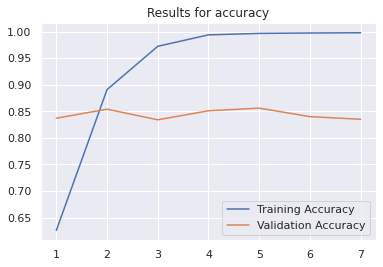

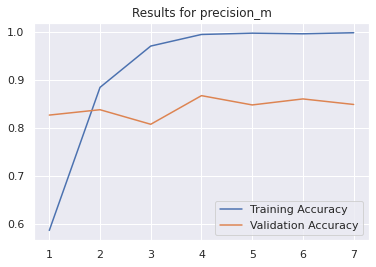

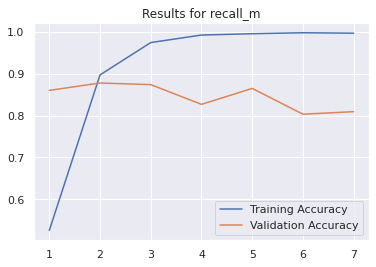

In [44]:
# Plot basic evaluation metrics across epochs
import matplotlib.pyplot as plt
%matplotlib inline

for i in ['accuracy', 'precision_m', 'recall_m']:
    acc = history.history[i]
    val_acc = history.history['val_{}'.format(i)]
    epochs = range(1, len(acc) + 1)

    plt.figure()
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Results for {}'.format(i))
    plt.legend()
    plt.show()

In [45]:
losses = pd.DataFrame(model.history.history)

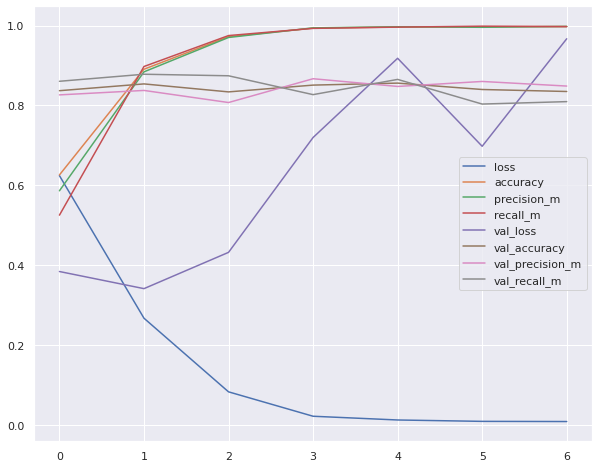

In [50]:
losses.plot()

Compare models

In [52]:
# TF-IDF + RF: Precision: 0.87 / Recall: 0.827 / Accuracy: 0.853
# word2vec + RF: Precision: 0.575 / Recall: 0.518 / Accuracy: 0.571
# RNN:  val_precision_m: 0.8486 / val_recall_m: 0.8096 / val_accuracy: 0.8350 

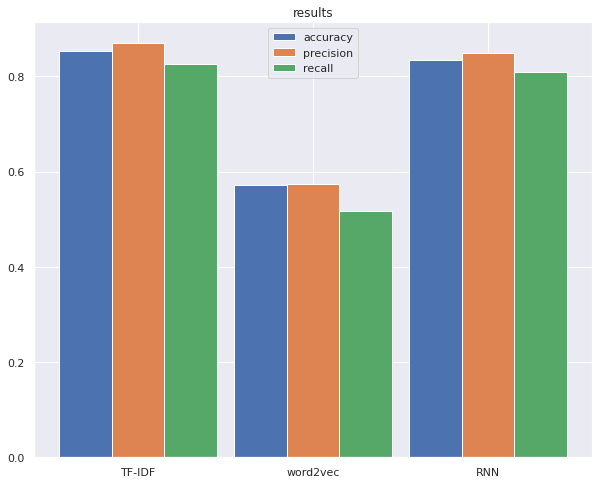

In [54]:
import numpy as np 
import matplotlib.pyplot as plt 
  
X = ['TF-IDF','word2vec','RNN']
accuracy=[0.853,	0.571,	0.835]
precision = [0.87,0.575,0.8486]
recall=[0.827,	0.518,	0.8096]

plt.figure(figsize=(10,8))  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.3, accuracy, 0.3, label = 'accuracy')
plt.bar(X_axis, precision, 0.3, label = 'precision')
plt.bar(X_axis + 0.3, recall, 0.3, label ='recall')

plt.xticks(X_axis, X)
plt.title("results")
plt.legend()
plt.show()